<a href="https://colab.research.google.com/github/YaassminSalahEldin/Heart-Disease-Prediction/blob/main/Heart_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
!pip install seaborn scikit-learn matplotlib pandas numpy

#Import Libraries

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc

from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2, SelectKBest, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering

import joblib

#Upload Data

In [56]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
col_names = ["age","sex","cp","trestbps","chol","fbs","restecg",
             "thalach","exang","oldpeak","slope","ca","thal","target"]

df = pd.read_csv(url, names=col_names, na_values="?")

print("Shape:", df.shape)
print(df.head())

Shape: (303, 14)
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0       0  
1    2.0  3.0   3.0       2  
2    2.0  2.0   7.0       1  
3    3.0  0.0   3.0       0  
4    1.0  0.0   3.0       0  


# Handle missing values

In [57]:
df = df.dropna()

# Encode categorical variables if needed

In [58]:
df = pd.get_dummies(df, drop_first=True)

# Scale numerical features

In [59]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.drop("target", axis=1))

X = pd.DataFrame(scaled_data, columns=df.drop("target", axis=1).columns)
y = df["target"].apply(lambda x: 1 if x > 0 else 0)  # Convert to binary classification



# EDA - Correlation Heatmap


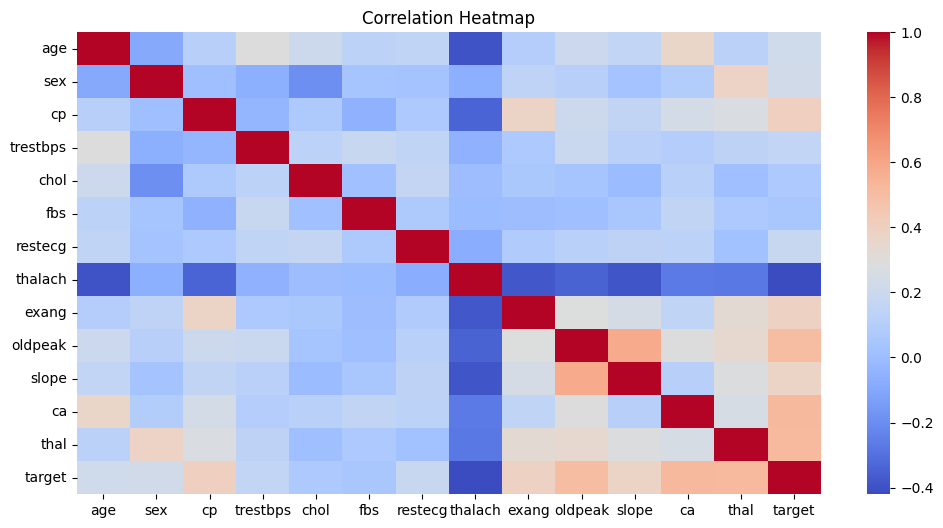

In [60]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

#PCA

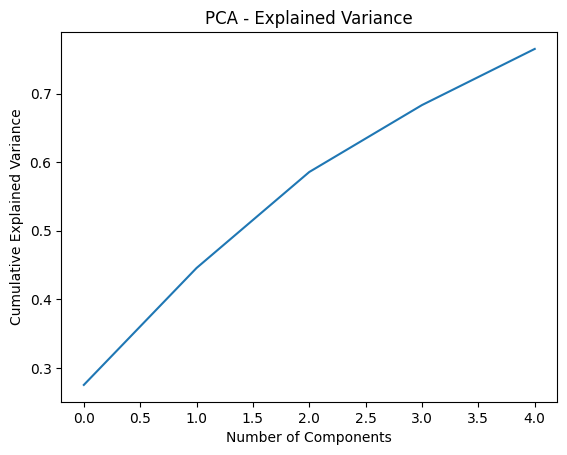

In [61]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Explained Variance")
plt.show()

# Random Forest Importance

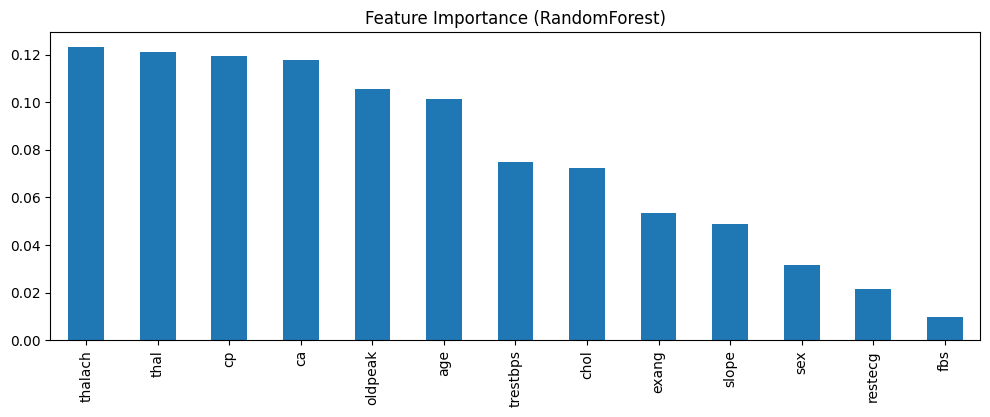

In [62]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
feat_imp.plot(kind="bar", figsize=(12,4), title="Feature Importance (RandomForest)")
plt.show()

# RFE with Logistic Regression

In [63]:
model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X, y)
print("Selected features by RFE:", X.columns[rfe.support_])

Selected features by RFE: Index(['sex', 'cp', 'trestbps', 'chol', 'thalach', 'exang', 'oldpeak', 'slope',
       'ca', 'thal'],
      dtype='object')


# Chi-Square Test

In [64]:
chi2_selector = SelectKBest(chi2, k=10)
chi2_selector.fit(X, y)
print("Selected features by Chi2:", X.columns[chi2_selector.get_support()])

Selected features by Chi2: Index(['age', 'sex', 'cp', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope',
       'ca', 'thal'],
      dtype='object')


#Split Data

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Models

In [66]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True)
}


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91        36
           1       0.85      0.92      0.88        24

    accuracy                           0.90        60
   macro avg       0.89      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60


Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.88      0.78      0.82        36
           1       0.71      0.83      0.77        24

    accuracy                           0.80        60
   macro avg       0.79      0.81      0.80        60
weighted avg       0.81      0.80      0.80        60


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        36
           1       0.84      0.88      0.86        24

    accuracy                           0.88        60
   macro avg       0.88      0.88     

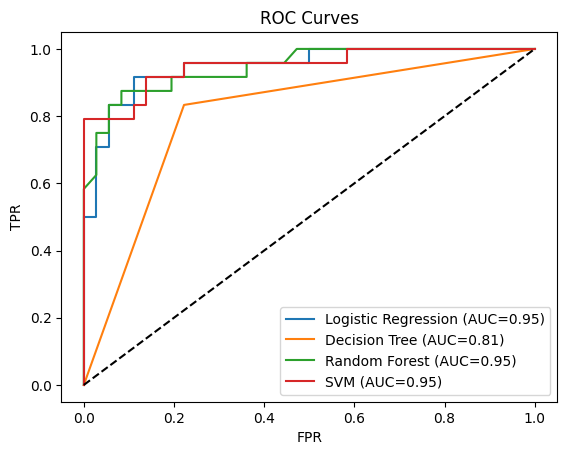

In [67]:
for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],"k--")
plt.title("ROC Curves")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()


# KMeans

In [68]:
kmeans = KMeans(n_clusters=2, random_state=42)
df["kmeans_cluster"] = kmeans.fit_predict(X)

In [69]:
hier = AgglomerativeClustering(n_clusters=2)
df["hier_cluster"] = hier.fit_predict(X)

print("Cluster comparison with true labels:")
print(pd.crosstab(df["target"], df["kmeans_cluster"]))
print(pd.crosstab(df["target"], df["hier_cluster"]))

Cluster comparison with true labels:
kmeans_cluster    0   1
target                 
0               126  34
1                19  35
2                 5  30
3                 2  33
4                 0  13
hier_cluster   0    1
target               
0             48  112
1             38   16
2             31    4
3             32    3
4             12    1


In [70]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5, 10]
}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring="accuracy", n_jobs=-1)
grid.fit(X_train, y_train)

print("Best RF Parameters:", grid.best_params_)
print("Best RF Accuracy:", grid.best_score_)

Best RF Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
Best RF Accuracy: 0.810126582278481


#Save Best Model

In [71]:
best_model = grid.best_estimator_
joblib.dump(best_model, "final_model.pkl")
print("✅ Model saved as final_model.pkl")

✅ Model saved as final_model.pkl


# Write the Streamlit app

In [72]:
!pip install streamlit pyngrok -q

In [73]:
%%writefile app.py
import streamlit as st
import joblib
import numpy as np

Overwriting app.py


# Load trained model

In [74]:
model = joblib.load("final_model.pkl")

In [75]:
import streamlit as st
st.title("❤️ Heart Disease Prediction App")

st.markdown("Enter your health data below:")

2025-08-21 04:48:16.374 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 04:48:16.375 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 04:48:16.377 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 04:48:16.378 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 04:48:16.380 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 04:48:16.381 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

# Define input fields based on dataset features

In [76]:
age = st.number_input("Age", 20, 100, 50)
sex = st.selectbox("Sex (1 = Male, 0 = Female)", [0, 1])
cp = st.selectbox("Chest Pain Type (0-3)", [0,1,2,3])
trestbps = st.number_input("Resting Blood Pressure (mm Hg)", 80, 200, 120)
chol = st.number_input("Cholesterol (mg/dl)", 100, 600, 200)
fbs = st.selectbox("Fasting Blood Sugar > 120 mg/dl (1 = True, 0 = False)", [0,1])
restecg = st.selectbox("Resting ECG (0-2)", [0,1,2])
thalach = st.number_input("Max Heart Rate Achieved", 60, 220, 150)
exang = st.selectbox("Exercise Induced Angina (1 = Yes, 0 = No)", [0,1])
oldpeak = st.number_input("ST Depression Induced by Exercise", 0.0, 6.0, 1.0, step=0.1)
slope = st.selectbox("Slope of Peak Exercise ST Segment (0-2)", [0,1,2])
ca = st.selectbox("Number of Major Vessels (0-3)", [0,1,2,3])
thal = st.selectbox("Thalassemia (1 = Normal, 2 = Fixed Defect, 3 = Reversible Defect)", [1,2,3])

2025-08-21 04:48:16.395 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 04:48:16.398 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 04:48:16.399 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 04:48:16.401 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 04:48:16.402 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 04:48:16.403 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 04:48:16.404 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 04:48:16.405 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

# Create input array

In [77]:
features = np.array([[age, sex, cp, trestbps, chol, fbs, restecg,
                      thalach, exang, oldpeak, slope, ca, thal]])

if st.button("Predict"):
    prediction = model.predict(features)[0]
    proba = model.predict_proba(features)[0][1]

    if prediction == 1:
        st.error(f"⚠️ High risk of Heart Disease (Probability: {proba:.2f})")
    else:
        st.success(f"✅ Low risk of Heart Disease (Probability: {proba:.2f})")

2025-08-21 04:48:16.524 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 04:48:16.531 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 04:48:16.533 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 04:48:16.536 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 04:48:16.538 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 04:48:16.543 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [81]:
from pyngrok import ngrok
import time

# Kill old processes
ngrok.kill()
!pkill streamlit

# Start Streamlit in background
!streamlit run app.py --server.port 8501 &

# Wait a bit for it to boot
time.sleep(5)

# Start ngrok tunnel
ngrok.set_auth_token("31AFfMRgRZabFIxAaod1vCUm36i_355JpQdwkhWg6Fc4U9RUC")
public_url = ngrok.connect(8501)
print("🌐 Public URL:", public_url)





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.48.168.80:8501

  Stopping...
🌐 Public URL: NgrokTunnel: "https://178e63c26887.ngrok-free.app" -> "http://localhost:8501"


In [79]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
import joblib

# Train RandomForest
rf = RandomForestClassifier(n_estimators=200, random_state=42)

# Calibrate probabilities
calibrated_rf = CalibratedClassifierCV(rf, method="sigmoid", cv=5)
calibrated_rf.fit(X_train, y_train)

# Save the calibrated model
joblib.dump(calibrated_rf, "final_model.pkl")

print("✅ Calibrated model saved as final_model.pkl")


✅ Calibrated model saved as final_model.pkl


#Gradio Interface

In [82]:
!pip install gradio -q

import gradio as gr
import joblib
import numpy as np

# Load trained calibrated model
model = joblib.load("final_model.pkl")

# Prediction function
def predict(age, sex, cp, trestbps, chol, fbs, restecg,
            thalach, exang, oldpeak, slope, ca, thal):

    features = np.array([[age, sex, cp, trestbps, chol, fbs, restecg,
                          thalach, exang, oldpeak, slope, ca, thal]])

    proba = model.predict_proba(features)[0][1]  # probability of "disease"

    # Use custom threshold (0.6 instead of 0.5)
    if proba > 0.75:
      return f"⚠️ High risk of Heart Disease (Probability: {proba:.2f})"
    elif proba >= 0.45 and proba <= 0.75:
      return f"⚠️ Borderline risk of Heart Disease (Probability: {proba:.2f})"
    else:
      return f"✅ Low risk of Heart Disease (Probability: {proba:.2f})"

# Define Gradio interface
iface = gr.Interface(
    fn=predict,
    inputs=[
        gr.Number(label="Age"),
        gr.Radio([0,1], label="Sex (1=Male, 0=Female)"),
        gr.Radio([0,1,2,3], label="Chest Pain Type (0–3)"),
        gr.Number(label="Resting Blood Pressure (mm Hg)"),
        gr.Number(label="Cholesterol (mg/dl)"),
        gr.Radio([0,1], label="Fasting Blood Sugar > 120 mg/dl (1=True, 0=False)"),
        gr.Radio([0,1,2], label="Resting ECG (0–2)"),
        gr.Number(label="Max Heart Rate Achieved"),
        gr.Radio([0,1], label="Exercise Induced Angina (1=Yes, 0=No)"),
        gr.Number(label="ST Depression Induced by Exercise"),
        gr.Radio([0,1,2], label="Slope of Peak Exercise ST Segment (0–2)"),
        gr.Radio([0,1,2,3], label="Number of Major Vessels (0–3)"),
        gr.Radio([1,2,3], label="Thalassemia (1=Normal, 2=Fixed, 3=Reversible)")
    ],
    outputs="text",
    title="❤️ Heart Disease Prediction",
    description="Enter your health data below to predict the risk of heart disease.\n\n"
                "⚠️ Note: High risk is flagged only if probability > 0.6"
)

# Launch with public link
iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6bbbc57656255662fd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
